In [1]:
import random
import array

from deap import base
from deap import creator
from deap import tools

import sys
sys.path.insert(1, '/path/to/Wind Farm Evaluator')
from Vec_modified import *

In [2]:
def get_random_arrangement(n_turbs):

    def get_point():
        """Returns random integer from 50 to 3950 inclusive"""
        return random.uniform(50,3950)


    def is_valid(point):
        """Checks if given point is valid"""
        point = np.array(point)
        point = np.reshape(point,(1,2))
        # getting array of distances to every other point
        dist = np.linalg.norm(turbine_pos - point,axis=1)

        return min(dist) > 400   # 400 is the problem constraint

    turbine_pos = np.full((n_turbs,2),np.inf)
    count = 0
    ans = []
    while count < n_turbs:
        point = [get_point(),get_point()] # x,y
        if is_valid(point):
            turbine_pos[count,:] = point
            ans.extend(list(point))
            count += 1

    return ans

In [3]:
def get_args(n_turbs):
    # setting turbine radius
    turb_rad = 50.0

    # Loading the power curve
    power_curve   =  loadPowerCurve('C:/Users/awals/Downloads/Shell AI Hackathon/Shell_Hackathon Dataset/power_curve.csv')

    # Loading wind data 
    years = ['07','08','09','13','14','15','17']
    wind_inst_freqs = []
    for y in years:
        wind_inst_freqs.append(binWindResourceData(f'C:/Users/awals/Downloads/Shell AI Hackathon/Shell_Hackathon Dataset/Wind Data/wind_data_20{y}.csv'))
    
    # preprocessing the wind data to avoid repeated calculations
    n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve,n_turbs)

    kwargs = {'turb_rad': turb_rad, 'power_curve': power_curve, 'wind_inst_freqs': wind_inst_freqs,
            'n_wind_instances': n_wind_instances, 'cos_dir': cos_dir, 'sin_dir': sin_dir, 'wind_sped_stacked': wind_sped_stacked,
            'C_t': C_t}

    return kwargs

def peri_constraint(turb_coords):
    peri_val = 0
    for turb in turb_coords:
        for val in turb:
            if val < 50:
                peri_val += (50 - val)
            elif val > 3950:
                peri_val += (val - 3950)
                
    return peri_val

def proxi_constraint(turb_coords):
    """
        Function to penalize if proximity contraint is violated.
        turb_coords is a 2d numpy array with N (xi,yi) elements.
    """
    proxi_val = 0
    for i in range(turb_coords.shape[0]-1):
        for j in range(i+1,turb_coords.shape[0]-1):
            norm = np.linalg.norm(turb_coords[i]-turb_coords[j])
            proxi_val += max(0,400 - norm)

    return proxi_val


def evaluate(individual, n_turbs, turb_rad, power_curve, wind_inst_freqs, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t):
    """
        Function to return values of both objectives as a tuple
    """

    # rearranging the terms in individual to pass to getAEP
    turb_coords = np.array([[individual[i],individual[i+1]] for i in range(0,2*n_turbs-1,2)])

    # calculating meanAEP for 
    mean_AEP = 0
    for wind_inst_freq in wind_inst_freqs:
        mean_AEP += getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)
    mean_AEP /= len(wind_inst_freqs)
    
    proxi_val = proxi_constraint(turb_coords)
    
    peri_val = peri_constraint(turb_coords)
    
    ideal_AEP = 11.297*n_turbs  # 11.297 is the mean score for 1 turbine
    
    return mean_AEP/ideal_AEP, proxi_val, peri_val  # First objective should be closest to 1 and second closest to zero

def initES(icls, scls, size, FLT_MIN, FLT_MAX, smin, smax):
    """
        Initialization function for an individual
    """
    # initializing an individual
    # ind = icls(random.uniform(FLT_MIN, FLT_MAX) for _ in range(size))
    ind = icls(get_random_arrangement(size//2))
    # initializing the individual's strategy
    ind.strategy = scls(random.uniform(smin,smax) for _ in range(size))

    return ind

In [4]:
n_turbs = 20

# creating a multi-objective Fitness criterio, with maximizing first and minimizing second
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -100.0, -100000.0)) 
# creating an individual (potential solution) as a vector of floats with a fitness and a strategy attribute
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMulti, strategy=None)
# defining the strategy attribute as a vector of floats (standard deviation for each dimension)
creator.create("Strategy", array.array, typecode="d")

# defining initial constraints
FLT_MIN = 50
FLT_MAX = 3950

# defining size of individual and strategy limits
N_DIM = n_turbs*2 
smin, smax = 10, 100  # min and max value for strategy

# creating a toolbox
toolbox = base.Toolbox()

# registering intiES in the toolbox with an alias "individual"
toolbox.register("individual", initES, creator.Individual, creator.Strategy, N_DIM, FLT_MIN, FLT_MAX, smin, smax)
# registering a 'population' function that will create a population(set) of n individuals (n : parameter)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# SPEA

N_CHILD = 50
N_PARENT = 4
N_ELITE = 3
TOURN_SIZE = N_CHILD//N_PARENT


Offspring = toolbox.population(n=N_CHILD)

MAX_GENS = 100
CROSS_PROB = 0.8    # probability of cross for each attribute
MUT_PROB = 0.5  # probability of mutation of an individual

# calculating kwargs once for repeated use
kwargs = get_args(n_turbs)

In [5]:
Elite = list()
for g in range(MAX_GENS):
    # evaluating obj function values for each individual
    for ind in Offspring:
        ind.fitness.values = evaluate(ind, n_turbs, **kwargs)

    # selecting the 5 non-dominated individuals
    dominating = tools.selSPEA2(Offspring, N_ELITE)

    # adding dominating individuals in Elite
    Elite_sel = [toolbox.clone(ind) for ind in dominating]
    Elite.extend(Elite_sel)

    # reducing the size of Elite
    Elite = tools.selSPEA2(Elite, N_ELITE)

    # creating the parent population by tournament selection
    Parent_sel = tools.selTournament([*Offspring, *Elite], N_PARENT, TOURN_SIZE, fit_attr='fitness')
    Parent = [toolbox.clone(ind) for ind in Parent_sel]

    # doing uniform cross-over and mutating
    Offspring = []
    for i in range(N_CHILD//2):
        ind1, ind2 = map(toolbox.clone, tools.selRandom(Parent,2))
        child1, child2 = tools.cxUniform(ind1, ind2, CROSS_PROB)
        for child in [child1, child2]:
            Offspring.append(tools.mutESLogNormal(child, 1, MUT_PROB)[0]) # returns tuple so [0]

    if g%(MAX_GENS//10) == 0:
        print(g//(MAX_GENS//10)*10,end='')
    elif g%(MAX_GENS//100) == 0:
        print('*',end='')
print(100)

0*********10*********20*********30*********40*********50*********60*********70*********80*********90*********100


In [6]:
for ind in Offspring:
    ind.fitness.values = evaluate(ind, n_turbs, **kwargs)

# selecting the 5 non-dominated individuals
dominating = tools.selSPEA2(Offspring, N_ELITE)

# adding dominating individuals in Elite
Elite_sel = [toolbox.clone(ind) for ind in dominating]
Elite.extend(Elite_sel)

# reducing the size of Elite
Elite = tools.selSPEA2(Elite, N_ELITE)

In [7]:
for ind in Elite:
    print(ind.fitness.values)       # best so far 0.90179671294 (564.85 is idealAEP)

(0.9618292063130575, 0.0, 0.0)
(0.9831236517527789, 0.0, 25405.9517505737)
(0.987820997529885, 0.0, 49729.7592615792)


In [8]:
print(11.297*n_turbs)

225.94


In [9]:
rand_ind = toolbox.individual()
evaluate(rand_ind, n_turbs, **kwargs)[0]

0.9443944377414607

In [10]:
turb_coords = np.array([[Elite[0][i],Elite[0][i+1]] for i in range(0,2*n_turbs-1,2)])
turbines = pd.DataFrame(turb_coords,columns=['x','y'])

Both perimeter and proximity constraints are satisfied !!



()

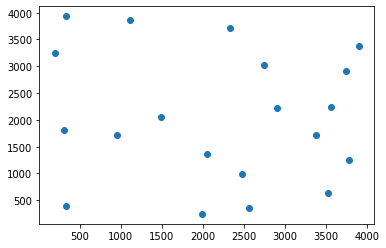

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(turb_coords[:,0],turb_coords[:,1])
checkConstraints(turb_coords,100.0)

In [12]:
# turbines.to_csv("C:/Users/awals/Downloads/Shell AI Hackathon/Wind Farm Evaluator/my_trials/second_deap_ans.csv",index=False)